In [211]:
ROOT = './'
DATASETS = ROOT + 'datasets/'
MODELS = ROOT + 'models/'
MESHES = ROOT + 'meshes/'

In [84]:
import numpy as np
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

tseed = 1234
criterion = nn.BCEWithLogitsLoss()
torch.manual_seed(tseed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [85]:
batch_size = 50

dataset = np.load(DATASETS+'dataset.npy', allow_pickle=True).item()

mdl_tr_br = [torch.from_numpy(np.array([model])*2-1).float().to(device) for model in dataset['train']['broken']]
mdl_tr_tg = [torch.from_numpy(np.array([model])*2-1).float().to(device) for model in dataset['train']['target']]

dataloader = DataLoader(list(zip(mdl_tr_br, mdl_tr_tg)), batch_size=batch_size, shuffle=True)

In [190]:
idx = np.random.randint(0, len(mdl_tr_br))
idx

384

In [87]:
import matplotlib.pyplot as plt

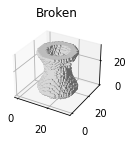

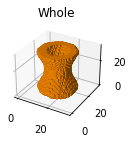

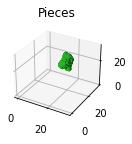

In [191]:
broken = torch.stack([mdl_tr_br[idx], ])
broken = broken[0][0].detach().cpu().numpy() > 0
ax1 = plt.figure().add_subplot(1, 3, 1, projection='3d')
ax1.set_title('Broken')
ax1.voxels(broken, facecolors='white', edgecolors='whitesmoke')

whole = torch.stack([mdl_tr_tg[idx], ])
whole = whole[0][0].detach().cpu().numpy() > 0
ax2 = plt.figure().add_subplot(1, 3, 2, projection='3d')
ax2.set_title('Whole')
ax2.voxels(whole, facecolors='orange', edgecolors='darkorange')

ax3 = plt.figure().add_subplot(1, 3, 3, projection='3d')
ax3.set_title('Pieces')
ax3.voxels(whole & ~broken, facecolors='lime', edgecolors='limegreen')

plt.show()

In [192]:
def down(i, o, batch=True, kernel_size=4, stride=1):
    layers = []
    layers.append(nn.Conv3d(
        i, o,
        kernel_size=kernel_size,
        stride=stride,
        bias=not batch
    ))
    if batch:
        layers.append(nn.BatchNorm3d(o))
    layers.append(nn.LeakyReLU(0.02))
    
    return nn.Sequential(*layers)


def up(i, o, dropout=False, kernel_size=4, stride=1):
    layers = []
    layers.append(nn.ConvTranspose3d(
        i, o,
        kernel_size=kernel_size,
        stride=stride,
        bias=False
    ))
    layers.append(nn.BatchNorm3d(o))
    
    if dropout:
        layers.append(nn.Dropout())
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [193]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.d1 = down( 1, 10, batch=False)
        self.d2 = down(10, 20)
        self.d3 = down(20, 40, stride=2)
        self.d4 = down(40, 40, stride=2)
        self.d5 = down(40, 40, stride=2, batch=False)
        
        self.u1 = up(40, 40, kernel_size=5)
        self.u2 = up(80, 40, stride=2)
        self.u3 = up(80, 20, stride=2)
        self.u4 = up(40, 10)
        
        self.res = nn.ConvTranspose3d(20, 1, 4)
        self.activator = nn.Tanh()
    
    def forward(self, x):
        s = []
        for elem in (self.d1, self.d2, self.d3, self.d4, self.d5):
            x = elem(x)
            s.append(x)
        
        s = s[:-1]
        
        x = self.u1(x)
        x = torch.cat((x, s[-1]), dim=1)
        x = self.u2(x)
        x = torch.cat((x, s[-2]), dim=1)
        x = self.u3(x)
        x = torch.cat((x, s[-3]), dim=1)
        x = self.u4(x)
        x = torch.cat((x, s[-4]), dim=1)
        
        return self.activator(self.res(x))


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.d1 = down( 2, 16, batch=False)
        self.d2 = down(16, 32)
        self.d3 = down(32, 64, stride=2)
        self.d4 = down(64, 64, stride=2)
        
        self.res = nn.ConvTranspose3d(64, 1, 4)
        self.activator = nn.SiLU()
    
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        
        for elem in (self.d1, self.d2, self.d3, self.d4):
            x = elem(x)
        
        return self.activator(self.res(x))

In [194]:
def discriminator_loss(criterion, gen, dis, _in, _target):
    fake = gen(_in)
    fake_pred = dis(_in, fake)
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))

    real_pred = dis(_in, _target)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))
    
    return (real_loss + fake_loss)/2


_lambda = 100
def generator_loss(criterion, gen, dis, _in, _target, l):
    fake = gen(_in)
    fake_pred = dis(_in, fake)

    real_pred = dis(_in, _target)

    fake_loss = criterion(fake_pred, torch.ones_like(fake_pred))
    target_loss = torch.mean(torch.abs(_target-fake))

    return fake_loss + l * target_loss

In [198]:
gen = Generator().to(device)
dis = Discriminator().to(device)

In [196]:
# Optional
gen.load_state_dict(torch.load(MODELS+'gen_70.chk', map_location=device))
dis.load_state_dict(torch.load(MODELS+'dis_70.chk', map_location=device))

<All keys matched successfully>

In [200]:
lr = 0.0002
gen_optimizer = torch.optim.Adam(gen.parameters(), lr)
dis_optimizer = torch.optim.Adam(dis.parameters(), lr)

In [201]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
display_step = 5
save_each = 10
epochs = 100

steps = []
ys_gen = []
ys_dis = []

for epoch in range(epochs):
    if epoch % save_each == 0 or epoch == 0:
        print('--Creating checpoint...--')
        torch.save(gen.state_dict(), MODELS+f'gen_{epoch}.chk')
        torch.save(dis.state_dict(), MODELS+f'dis_{epoch}.chk')
    
    for _in, _target in tqdm(dataloader):
        dis_optimizer.zero_grad()
        dis_loss = discriminator_loss(criterion, gen, dis, _in, _target)
        dis_loss.backward(retain_graph=True)
        dis_optimizer.step()
        
        gen_optimizer.zero_grad()
        gen_loss = generator_loss(criterion, gen, dis, _in, _target, _lambda)
        gen_loss.backward()
        gen_optimizer.step()
        
        mean_discriminator_loss += dis_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % display_step == 0 and cur_step > 0:
            print(f'Step {cur_step} - Epoch {epoch+1}: Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}')
            steps.append(cur_step)
            
            ys_dis.append(mean_discriminator_loss)
            ys_gen.append(mean_generator_loss)
            
            mean_discriminator_loss = 0
            mean_generator_loss = 0
        cur_step += 1

--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 5 - Epoch 1: Generator loss: 74.57985382080078, Discriminator loss: 0.9677329063415526
Step 10 - Epoch 1: Generator loss: 40.38018722534179, Discriminator loss: 0.7100919604301452
Step 15 - Epoch 1: Generator loss: 29.164732360839842, Discriminator loss: 0.692877185344696


  0%|          | 0/19 [00:00<?, ?it/s]

Step 20 - Epoch 2: Generator loss: 23.112844467163086, Discriminator loss: 0.6928010940551758
Step 25 - Epoch 2: Generator loss: 19.17199020385742, Discriminator loss: 0.68698068857193
Step 30 - Epoch 2: Generator loss: 17.142274475097654, Discriminator loss: 0.6779712200164796
Step 35 - Epoch 2: Generator loss: 14.470217514038085, Discriminator loss: 0.6706853985786437


  0%|          | 0/19 [00:00<?, ?it/s]

Step 40 - Epoch 3: Generator loss: 12.812361907958984, Discriminator loss: 0.6579162955284118
Step 45 - Epoch 3: Generator loss: 12.361632347106934, Discriminator loss: 0.6376211404800416
Step 50 - Epoch 3: Generator loss: 11.414710807800294, Discriminator loss: 0.624096405506134
Step 55 - Epoch 3: Generator loss: 10.61091365814209, Discriminator loss: 0.61530601978302


  0%|          | 0/19 [00:00<?, ?it/s]

Step 60 - Epoch 4: Generator loss: 9.662437629699706, Discriminator loss: 0.6056096196174622
Step 65 - Epoch 4: Generator loss: 9.929107666015625, Discriminator loss: 0.5932507991790772
Step 70 - Epoch 4: Generator loss: 9.056093406677245, Discriminator loss: 0.5787688851356506
Step 75 - Epoch 4: Generator loss: 8.968891525268555, Discriminator loss: 0.5715957641601562


  0%|          | 0/19 [00:00<?, ?it/s]

Step 80 - Epoch 5: Generator loss: 8.564814376831055, Discriminator loss: 0.5605351567268372
Step 85 - Epoch 5: Generator loss: 7.940110778808593, Discriminator loss: 0.5502344369888306
Step 90 - Epoch 5: Generator loss: 7.866457557678223, Discriminator loss: 0.5384471774101257


  0%|          | 0/19 [00:00<?, ?it/s]

Step 95 - Epoch 6: Generator loss: 7.637690353393555, Discriminator loss: 0.5254606366157532
Step 100 - Epoch 6: Generator loss: 7.43393611907959, Discriminator loss: 0.5165935039520263
Step 105 - Epoch 6: Generator loss: 7.371739864349365, Discriminator loss: 0.5065382599830628
Step 110 - Epoch 6: Generator loss: 6.9221660614013665, Discriminator loss: 0.49513739943504337


  0%|          | 0/19 [00:00<?, ?it/s]

Step 115 - Epoch 7: Generator loss: 6.807634258270264, Discriminator loss: 0.48766425251960754
Step 120 - Epoch 7: Generator loss: 6.670075607299805, Discriminator loss: 0.477967631816864
Step 125 - Epoch 7: Generator loss: 6.508069896697998, Discriminator loss: 0.4711317300796508
Step 130 - Epoch 7: Generator loss: 6.572154903411866, Discriminator loss: 0.4647419273853302


  0%|          | 0/19 [00:00<?, ?it/s]

Step 135 - Epoch 8: Generator loss: 6.2725677490234375, Discriminator loss: 0.4568753898143768
Step 140 - Epoch 8: Generator loss: 5.935019397735596, Discriminator loss: 0.451302981376648
Step 145 - Epoch 8: Generator loss: 6.0183464050292965, Discriminator loss: 0.44433870911598206
Step 150 - Epoch 8: Generator loss: 5.7741827964782715, Discriminator loss: 0.4408238351345063


  0%|          | 0/19 [00:00<?, ?it/s]

Step 155 - Epoch 9: Generator loss: 5.768212795257568, Discriminator loss: 0.43746641278266907
Step 160 - Epoch 9: Generator loss: 5.758299446105957, Discriminator loss: 0.4294273734092712
Step 165 - Epoch 9: Generator loss: 5.702481842041015, Discriminator loss: 0.42645788192749023
Step 170 - Epoch 9: Generator loss: 5.428239822387695, Discriminator loss: 0.42253038883209226


  0%|          | 0/19 [00:00<?, ?it/s]

Step 175 - Epoch 10: Generator loss: 5.391291332244872, Discriminator loss: 0.4194452881813049
Step 180 - Epoch 10: Generator loss: 5.392392253875732, Discriminator loss: 0.41580053567886355
Step 185 - Epoch 10: Generator loss: 5.166028785705567, Discriminator loss: 0.41027353405952455
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 190 - Epoch 11: Generator loss: 5.230465602874756, Discriminator loss: 0.4095057308673859
Step 195 - Epoch 11: Generator loss: 5.050422573089599, Discriminator loss: 0.4055238485336303
Step 200 - Epoch 11: Generator loss: 4.930251598358154, Discriminator loss: 0.3987453877925873
Step 205 - Epoch 11: Generator loss: 5.136686992645263, Discriminator loss: 0.4014138519763946


  0%|          | 0/19 [00:00<?, ?it/s]

Step 210 - Epoch 12: Generator loss: 4.840296268463135, Discriminator loss: 0.3983060300350189
Step 215 - Epoch 12: Generator loss: 5.096099376678467, Discriminator loss: 0.39602661728858946
Step 220 - Epoch 12: Generator loss: 4.785372543334961, Discriminator loss: 0.39187670350074766
Step 225 - Epoch 12: Generator loss: 4.712790012359619, Discriminator loss: 0.3900476098060608


  0%|          | 0/19 [00:00<?, ?it/s]

Step 230 - Epoch 13: Generator loss: 4.591775608062744, Discriminator loss: 0.386777263879776
Step 235 - Epoch 13: Generator loss: 4.64955129623413, Discriminator loss: 0.3862332344055176
Step 240 - Epoch 13: Generator loss: 4.495135688781739, Discriminator loss: 0.38329673409461973
Step 245 - Epoch 13: Generator loss: 4.595526885986328, Discriminator loss: 0.3815409421920777


  0%|          | 0/19 [00:00<?, ?it/s]

Step 250 - Epoch 14: Generator loss: 4.574776268005372, Discriminator loss: 0.37849611639976505
Step 255 - Epoch 14: Generator loss: 4.291420793533325, Discriminator loss: 0.37597810029983525
Step 260 - Epoch 14: Generator loss: 4.39237813949585, Discriminator loss: 0.37571452260017396
Step 265 - Epoch 14: Generator loss: 4.4642706394195555, Discriminator loss: 0.3769175589084625


  0%|          | 0/19 [00:00<?, ?it/s]

Step 270 - Epoch 15: Generator loss: 4.373784303665161, Discriminator loss: 0.3718870162963867
Step 275 - Epoch 15: Generator loss: 4.34183874130249, Discriminator loss: 0.36966243386268616
Step 280 - Epoch 15: Generator loss: 4.342968845367432, Discriminator loss: 0.37030996680259703


  0%|          | 0/19 [00:00<?, ?it/s]

Step 285 - Epoch 16: Generator loss: 3.9744710445404055, Discriminator loss: 0.36517857313156127
Step 290 - Epoch 16: Generator loss: 4.03428020477295, Discriminator loss: 0.36567307114601133
Step 295 - Epoch 16: Generator loss: 4.401176071166993, Discriminator loss: 0.3621400117874145
Step 300 - Epoch 16: Generator loss: 4.165270614624023, Discriminator loss: 0.3631085455417633


  0%|          | 0/19 [00:00<?, ?it/s]

Step 305 - Epoch 17: Generator loss: 3.988296699523926, Discriminator loss: 0.3653602600097656
Step 310 - Epoch 17: Generator loss: 4.049089670181274, Discriminator loss: 0.362057101726532
Step 315 - Epoch 17: Generator loss: 3.961050510406494, Discriminator loss: 0.361548924446106
Step 320 - Epoch 17: Generator loss: 4.213686752319336, Discriminator loss: 0.3576970934867859


  0%|          | 0/19 [00:00<?, ?it/s]

Step 325 - Epoch 18: Generator loss: 4.041372632980347, Discriminator loss: 0.35360026359558105
Step 330 - Epoch 18: Generator loss: 4.082755851745605, Discriminator loss: 0.3516849756240845
Step 335 - Epoch 18: Generator loss: 3.8191940307617185, Discriminator loss: 0.3500575482845307
Step 340 - Epoch 18: Generator loss: 3.8513203144073485, Discriminator loss: 0.3478157162666321


  0%|          | 0/19 [00:00<?, ?it/s]

Step 345 - Epoch 19: Generator loss: 4.032592678070069, Discriminator loss: 0.3464397192001343
Step 350 - Epoch 19: Generator loss: 3.8698849201202394, Discriminator loss: 0.35319290757179267
Step 355 - Epoch 19: Generator loss: 3.7977828979492188, Discriminator loss: 0.35127829313278197
Step 360 - Epoch 19: Generator loss: 3.8298184394836423, Discriminator loss: 0.34988564252853394


  0%|          | 0/19 [00:00<?, ?it/s]

Step 365 - Epoch 20: Generator loss: 3.77245831489563, Discriminator loss: 0.34889438152313235
Step 370 - Epoch 20: Generator loss: 3.8462547779083254, Discriminator loss: 0.3534968316555023
Step 375 - Epoch 20: Generator loss: 3.6882039070129395, Discriminator loss: 0.3748646974563599
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 380 - Epoch 21: Generator loss: 3.7385765075683595, Discriminator loss: 0.37304772138595577
Step 385 - Epoch 21: Generator loss: 3.8487104892730715, Discriminator loss: 0.3663085997104645
Step 390 - Epoch 21: Generator loss: 3.6003928184509277, Discriminator loss: 0.3592993557453155
Step 395 - Epoch 21: Generator loss: 3.692939424514771, Discriminator loss: 0.3530805647373199


  0%|          | 0/19 [00:00<?, ?it/s]

Step 400 - Epoch 22: Generator loss: 3.6995346546173096, Discriminator loss: 0.3524373054504395
Step 405 - Epoch 22: Generator loss: 3.711018753051758, Discriminator loss: 0.3441258192062378
Step 410 - Epoch 22: Generator loss: 3.7343956947326657, Discriminator loss: 0.3404739499092102
Step 415 - Epoch 22: Generator loss: 3.5975343704223635, Discriminator loss: 0.33830028772354126


  0%|          | 0/19 [00:00<?, ?it/s]

Step 420 - Epoch 23: Generator loss: 3.473921203613281, Discriminator loss: 0.3325211346149444
Step 425 - Epoch 23: Generator loss: 3.553828763961792, Discriminator loss: 0.33037381768226626
Step 430 - Epoch 23: Generator loss: 3.7141068935394292, Discriminator loss: 0.331062114238739
Step 435 - Epoch 23: Generator loss: 3.5747472286224364, Discriminator loss: 0.3270156443119049


  0%|          | 0/19 [00:00<?, ?it/s]

Step 440 - Epoch 24: Generator loss: 3.49796142578125, Discriminator loss: 0.32532512545585635
Step 445 - Epoch 24: Generator loss: 3.445540332794189, Discriminator loss: 0.32346807122230525
Step 450 - Epoch 24: Generator loss: 3.599177598953247, Discriminator loss: 0.3212517261505127
Step 455 - Epoch 24: Generator loss: 3.6224645614624027, Discriminator loss: 0.32095073461532597


  0%|          | 0/19 [00:00<?, ?it/s]

Step 460 - Epoch 25: Generator loss: 3.518799448013306, Discriminator loss: 0.31988686323165894
Step 465 - Epoch 25: Generator loss: 3.5614537715911867, Discriminator loss: 0.3181217610836029
Step 470 - Epoch 25: Generator loss: 3.4646230220794676, Discriminator loss: 0.3160741150379181


  0%|          | 0/19 [00:00<?, ?it/s]

Step 475 - Epoch 26: Generator loss: 3.4580728530883786, Discriminator loss: 0.31646822690963744
Step 480 - Epoch 26: Generator loss: 3.4611479759216306, Discriminator loss: 0.31783799529075624
Step 485 - Epoch 26: Generator loss: 3.408295488357544, Discriminator loss: 0.3170926988124847
Step 490 - Epoch 26: Generator loss: 3.642714500427246, Discriminator loss: 0.31718416810035704


  0%|          | 0/19 [00:00<?, ?it/s]

Step 495 - Epoch 27: Generator loss: 3.4077710151672362, Discriminator loss: 0.33044171929359434
Step 500 - Epoch 27: Generator loss: 3.421272659301758, Discriminator loss: 0.3258398175239563
Step 505 - Epoch 27: Generator loss: 3.3844032764434813, Discriminator loss: 0.32268453836441036
Step 510 - Epoch 27: Generator loss: 3.430781745910644, Discriminator loss: 0.31934577226638794


  0%|          | 0/19 [00:00<?, ?it/s]

Step 515 - Epoch 28: Generator loss: 3.2979246616363525, Discriminator loss: 0.31644968390464784
Step 520 - Epoch 28: Generator loss: 3.3448657035827636, Discriminator loss: 0.31343294978141784
Step 525 - Epoch 28: Generator loss: 3.543978357315064, Discriminator loss: 0.3117508888244629
Step 530 - Epoch 28: Generator loss: 3.3888731956481934, Discriminator loss: 0.3095019221305847


  0%|          | 0/19 [00:00<?, ?it/s]

Step 535 - Epoch 29: Generator loss: 3.364525461196899, Discriminator loss: 0.3100545406341553
Step 540 - Epoch 29: Generator loss: 3.381409358978271, Discriminator loss: 0.3076672852039337
Step 545 - Epoch 29: Generator loss: 3.372296762466431, Discriminator loss: 0.30573676228523256
Step 550 - Epoch 29: Generator loss: 3.270882606506347, Discriminator loss: 0.3068148970603943


  0%|          | 0/19 [00:00<?, ?it/s]

Step 555 - Epoch 30: Generator loss: 3.476115798950195, Discriminator loss: 0.3064553439617157
Step 560 - Epoch 30: Generator loss: 3.3891672611236574, Discriminator loss: 0.31007831692695614
Step 565 - Epoch 30: Generator loss: 3.2022097587585447, Discriminator loss: 0.30630765557289125
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 570 - Epoch 31: Generator loss: 3.2466073036193848, Discriminator loss: 0.30680881142616273
Step 575 - Epoch 31: Generator loss: 3.3449032306671143, Discriminator loss: 0.30464908480644226
Step 580 - Epoch 31: Generator loss: 3.305117130279541, Discriminator loss: 0.30523594617843625
Step 585 - Epoch 31: Generator loss: 3.4132990360260007, Discriminator loss: 0.30428864955902096


  0%|          | 0/19 [00:00<?, ?it/s]

Step 590 - Epoch 32: Generator loss: 3.232695150375366, Discriminator loss: 0.30405773520469664
Step 595 - Epoch 32: Generator loss: 3.244458103179932, Discriminator loss: 0.30405126214027406
Step 600 - Epoch 32: Generator loss: 3.1821642398834227, Discriminator loss: 0.3036107659339905
Step 605 - Epoch 32: Generator loss: 3.367458772659302, Discriminator loss: 0.30299649238586424


  0%|          | 0/19 [00:00<?, ?it/s]

Step 610 - Epoch 33: Generator loss: 3.33474588394165, Discriminator loss: 0.3031835913658142
Step 615 - Epoch 33: Generator loss: 3.210597276687622, Discriminator loss: 0.31458296775817873
Step 620 - Epoch 33: Generator loss: 3.20120792388916, Discriminator loss: 0.3149603009223938
Step 625 - Epoch 33: Generator loss: 3.2497221946716306, Discriminator loss: 0.31278362274169924


  0%|          | 0/19 [00:00<?, ?it/s]

Step 630 - Epoch 34: Generator loss: 3.344287872314453, Discriminator loss: 0.3110043942928314
Step 635 - Epoch 34: Generator loss: 3.1864780426025394, Discriminator loss: 0.3095446705818176
Step 640 - Epoch 34: Generator loss: 3.15964937210083, Discriminator loss: 0.307271808385849
Step 645 - Epoch 34: Generator loss: 3.3017608642578122, Discriminator loss: 0.3062256217002869


  0%|          | 0/19 [00:00<?, ?it/s]

Step 650 - Epoch 35: Generator loss: 3.154095268249512, Discriminator loss: 0.3055802881717682
Step 655 - Epoch 35: Generator loss: 3.277034568786621, Discriminator loss: 0.3053263008594513
Step 660 - Epoch 35: Generator loss: 3.108606290817261, Discriminator loss: 0.30449231863021853


  0%|          | 0/19 [00:00<?, ?it/s]

Step 665 - Epoch 36: Generator loss: 3.2701461315155025, Discriminator loss: 0.30277678966522215
Step 670 - Epoch 36: Generator loss: 3.2523680686950684, Discriminator loss: 0.30287075638771055
Step 675 - Epoch 36: Generator loss: 3.2705980300903317, Discriminator loss: 0.3011387467384338
Step 680 - Epoch 36: Generator loss: 3.147416639328003, Discriminator loss: 0.30176979899406436


  0%|          | 0/19 [00:00<?, ?it/s]

Step 685 - Epoch 37: Generator loss: 3.1192110061645506, Discriminator loss: 0.3008731007575989
Step 690 - Epoch 37: Generator loss: 3.111729145050049, Discriminator loss: 0.30414233803749086
Step 695 - Epoch 37: Generator loss: 3.2197296142578127, Discriminator loss: 0.30622350573539736
Step 700 - Epoch 37: Generator loss: 3.2282862186431887, Discriminator loss: 0.30121035575866695


  0%|          | 0/19 [00:00<?, ?it/s]

Step 705 - Epoch 38: Generator loss: 3.089889717102051, Discriminator loss: 0.30475050806999204
Step 710 - Epoch 38: Generator loss: 3.1047928810119627, Discriminator loss: 0.30615313053131105
Step 715 - Epoch 38: Generator loss: 3.177055835723877, Discriminator loss: 0.3043662130832672
Step 720 - Epoch 38: Generator loss: 3.21704740524292, Discriminator loss: 0.3023856282234192


  0%|          | 0/19 [00:00<?, ?it/s]

Step 725 - Epoch 39: Generator loss: 2.891161012649536, Discriminator loss: 0.30162122249603274
Step 730 - Epoch 39: Generator loss: 3.1590980052947994, Discriminator loss: 0.2988982439041138
Step 735 - Epoch 39: Generator loss: 3.2182007312774656, Discriminator loss: 0.2998572885990143
Step 740 - Epoch 39: Generator loss: 3.245491933822632, Discriminator loss: 0.29908934235572815


  0%|          | 0/19 [00:00<?, ?it/s]

Step 745 - Epoch 40: Generator loss: 3.307884836196899, Discriminator loss: 0.29856034517288205
Step 750 - Epoch 40: Generator loss: 3.058803987503052, Discriminator loss: 0.2986309289932251
Step 755 - Epoch 40: Generator loss: 3.051329898834229, Discriminator loss: 0.2984237611293793
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 760 - Epoch 41: Generator loss: 2.9610552310943605, Discriminator loss: 0.29666908383369445
Step 765 - Epoch 41: Generator loss: 3.0524670124053954, Discriminator loss: 0.2979187428951263
Step 770 - Epoch 41: Generator loss: 3.075885057449341, Discriminator loss: 0.2976930320262909
Step 775 - Epoch 41: Generator loss: 3.2409299850463866, Discriminator loss: 0.29906622171401975


  0%|          | 0/19 [00:00<?, ?it/s]

Step 780 - Epoch 42: Generator loss: 3.1540314197540282, Discriminator loss: 0.30268676280975343
Step 785 - Epoch 42: Generator loss: 3.0290488719940187, Discriminator loss: 0.3173528432846069
Step 790 - Epoch 42: Generator loss: 3.063692188262939, Discriminator loss: 0.3125282287597656
Step 795 - Epoch 42: Generator loss: 3.0330073833465576, Discriminator loss: 0.30858359336853025


  0%|          | 0/19 [00:00<?, ?it/s]

Step 800 - Epoch 43: Generator loss: 3.0070560932159425, Discriminator loss: 0.3110437154769898
Step 805 - Epoch 43: Generator loss: 3.054637908935547, Discriminator loss: 0.3064117193222046
Step 810 - Epoch 43: Generator loss: 3.1616728782653807, Discriminator loss: 0.30561336874961853
Step 815 - Epoch 43: Generator loss: 3.075386714935303, Discriminator loss: 0.30366643667221066


  0%|          | 0/19 [00:00<?, ?it/s]

Step 820 - Epoch 44: Generator loss: 2.9705277442932125, Discriminator loss: 0.3020787239074707
Step 825 - Epoch 44: Generator loss: 3.0443605899810793, Discriminator loss: 0.3021073698997498
Step 830 - Epoch 44: Generator loss: 3.1835747241973875, Discriminator loss: 0.3026039838790894
Step 835 - Epoch 44: Generator loss: 3.0248310565948486, Discriminator loss: 0.2995867788791656


  0%|          | 0/19 [00:00<?, ?it/s]

Step 840 - Epoch 45: Generator loss: 3.0178364276885983, Discriminator loss: 0.30038709044456485
Step 845 - Epoch 45: Generator loss: 3.0728056907653807, Discriminator loss: 0.29886390566825866
Step 850 - Epoch 45: Generator loss: 3.031632089614868, Discriminator loss: 0.29805984497070315


  0%|          | 0/19 [00:00<?, ?it/s]

Step 855 - Epoch 46: Generator loss: 3.0742415904998777, Discriminator loss: 0.296827107667923
Step 860 - Epoch 46: Generator loss: 3.042400407791138, Discriminator loss: 0.2964529752731323
Step 865 - Epoch 46: Generator loss: 3.1042551994323726, Discriminator loss: 0.2968981325626373
Step 870 - Epoch 46: Generator loss: 2.977618265151978, Discriminator loss: 0.29616320729255674


  0%|          | 0/19 [00:00<?, ?it/s]

Step 875 - Epoch 47: Generator loss: 3.027953052520752, Discriminator loss: 0.29914002418518065
Step 880 - Epoch 47: Generator loss: 3.1085610389709473, Discriminator loss: 0.2966800510883331
Step 885 - Epoch 47: Generator loss: 2.9744829654693605, Discriminator loss: 0.29714820981025697
Step 890 - Epoch 47: Generator loss: 3.0005775451660157, Discriminator loss: 0.2973483085632324


  0%|          | 0/19 [00:00<?, ?it/s]

Step 895 - Epoch 48: Generator loss: 2.946641826629639, Discriminator loss: 0.29601057171821593
Step 900 - Epoch 48: Generator loss: 3.064952564239502, Discriminator loss: 0.2966034054756164
Step 905 - Epoch 48: Generator loss: 2.9815317630767817, Discriminator loss: 0.29566129446029665
Step 910 - Epoch 48: Generator loss: 3.024492835998535, Discriminator loss: 0.2954637587070465


  0%|          | 0/19 [00:00<?, ?it/s]

Step 915 - Epoch 49: Generator loss: 3.179557514190674, Discriminator loss: 0.2951669156551361
Step 920 - Epoch 49: Generator loss: 2.9216894626617433, Discriminator loss: 0.29439046382904055
Step 925 - Epoch 49: Generator loss: 2.9717255115509036, Discriminator loss: 0.2954730808734894
Step 930 - Epoch 49: Generator loss: 2.953805303573608, Discriminator loss: 0.2947410702705383


  0%|          | 0/19 [00:00<?, ?it/s]

Step 935 - Epoch 50: Generator loss: 2.928872871398926, Discriminator loss: 0.2942091703414917
Step 940 - Epoch 50: Generator loss: 3.040065336227417, Discriminator loss: 0.2948813498020172
Step 945 - Epoch 50: Generator loss: 3.0917426586151118, Discriminator loss: 0.2950224995613098
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 950 - Epoch 51: Generator loss: 2.8787456989288334, Discriminator loss: 0.29377025961875913
Step 955 - Epoch 51: Generator loss: 2.9870015144348145, Discriminator loss: 0.29462172985076907
Step 960 - Epoch 51: Generator loss: 3.062145137786865, Discriminator loss: 0.29449094533920284
Step 965 - Epoch 51: Generator loss: 2.9653225421905516, Discriminator loss: 0.29442166090011596


  0%|          | 0/19 [00:00<?, ?it/s]

Step 970 - Epoch 52: Generator loss: 2.8956923484802246, Discriminator loss: 0.2934083461761474
Step 975 - Epoch 52: Generator loss: 2.933457088470459, Discriminator loss: 0.293196964263916
Step 980 - Epoch 52: Generator loss: 2.9190154552459715, Discriminator loss: 0.293993604183197
Step 985 - Epoch 52: Generator loss: 3.121156787872314, Discriminator loss: 0.29359168410301206


  0%|          | 0/19 [00:00<?, ?it/s]

Step 990 - Epoch 53: Generator loss: 2.864525270462036, Discriminator loss: 0.2953468143939972
Step 995 - Epoch 53: Generator loss: 2.900499725341797, Discriminator loss: 0.3011318206787109
Step 1000 - Epoch 53: Generator loss: 2.9802671432495114, Discriminator loss: 0.3043254971504212
Step 1005 - Epoch 53: Generator loss: 3.073729944229126, Discriminator loss: 0.30170534253120423


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1010 - Epoch 54: Generator loss: 2.9203845024108883, Discriminator loss: 0.29954453706741335
Step 1015 - Epoch 54: Generator loss: 2.823367977142334, Discriminator loss: 0.2994209825992584
Step 1020 - Epoch 54: Generator loss: 3.101521062850952, Discriminator loss: 0.29652113914489747
Step 1025 - Epoch 54: Generator loss: 2.9772976398468023, Discriminator loss: 0.29630032181739807


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1030 - Epoch 55: Generator loss: 3.008159255981445, Discriminator loss: 0.2951898157596588
Step 1035 - Epoch 55: Generator loss: 3.0437257289886475, Discriminator loss: 0.2973118662834167
Step 1040 - Epoch 55: Generator loss: 2.7866769313812254, Discriminator loss: 0.29583747386932374


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1045 - Epoch 56: Generator loss: 2.9038162231445312, Discriminator loss: 0.2944835305213928
Step 1050 - Epoch 56: Generator loss: 2.9794311046600344, Discriminator loss: 0.2939254343509674
Step 1055 - Epoch 56: Generator loss: 2.8373530387878416, Discriminator loss: 0.2942416489124298
Step 1060 - Epoch 56: Generator loss: 3.000053024291992, Discriminator loss: 0.29488078951835633


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1065 - Epoch 57: Generator loss: 2.9276902198791506, Discriminator loss: 0.29526962041854854
Step 1070 - Epoch 57: Generator loss: 3.0072967529296877, Discriminator loss: 0.29368377327919004
Step 1075 - Epoch 57: Generator loss: 2.9348711967468257, Discriminator loss: 0.2943729758262634
Step 1080 - Epoch 57: Generator loss: 2.8698337078094482, Discriminator loss: 0.29424114823341374


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1085 - Epoch 58: Generator loss: 2.9762582778930664, Discriminator loss: 0.2927618741989136
Step 1090 - Epoch 58: Generator loss: 3.056553220748901, Discriminator loss: 0.29562780261039734
Step 1095 - Epoch 58: Generator loss: 2.833728361129761, Discriminator loss: 0.2941364169120788
Step 1100 - Epoch 58: Generator loss: 2.8732104778289793, Discriminator loss: 0.2946377158164978


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1105 - Epoch 59: Generator loss: 2.940040254592896, Discriminator loss: 0.293343859910965
Step 1110 - Epoch 59: Generator loss: 2.818836307525635, Discriminator loss: 0.29431783556938174
Step 1115 - Epoch 59: Generator loss: 2.8724896907806396, Discriminator loss: 0.29293617010116574
Step 1120 - Epoch 59: Generator loss: 3.058285760879517, Discriminator loss: 0.2945621430873871


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1125 - Epoch 60: Generator loss: 2.8809194564819336, Discriminator loss: 0.293846583366394
Step 1130 - Epoch 60: Generator loss: 2.9168118476867675, Discriminator loss: 0.29402552247047425
Step 1135 - Epoch 60: Generator loss: 2.952856254577637, Discriminator loss: 0.29240033626556394
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1140 - Epoch 61: Generator loss: 2.888268995285034, Discriminator loss: 0.2939552247524262
Step 1145 - Epoch 61: Generator loss: 2.9173213958740236, Discriminator loss: 0.29448725581169133
Step 1150 - Epoch 61: Generator loss: 2.9625735759735106, Discriminator loss: 0.29562363028526306
Step 1155 - Epoch 61: Generator loss: 2.8679758071899415, Discriminator loss: 0.29329448342323305


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1160 - Epoch 62: Generator loss: 3.005316352844238, Discriminator loss: 0.29233574271202084
Step 1165 - Epoch 62: Generator loss: 2.8231553077697753, Discriminator loss: 0.29335638880729675
Step 1170 - Epoch 62: Generator loss: 2.8574171543121336, Discriminator loss: 0.2926877737045288
Step 1175 - Epoch 62: Generator loss: 2.8385817050933837, Discriminator loss: 0.29264476299285885


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1180 - Epoch 63: Generator loss: 2.9362584590911864, Discriminator loss: 0.2987830460071564
Step 1185 - Epoch 63: Generator loss: 2.814021444320679, Discriminator loss: 0.2962133169174195
Step 1190 - Epoch 63: Generator loss: 2.7457530975341795, Discriminator loss: 0.2948075234889984
Step 1195 - Epoch 63: Generator loss: 3.013523197174072, Discriminator loss: 0.29485884308815


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1200 - Epoch 64: Generator loss: 2.821295022964478, Discriminator loss: 0.2958464801311493
Step 1205 - Epoch 64: Generator loss: 2.849621200561523, Discriminator loss: 0.29329280853271483
Step 1210 - Epoch 64: Generator loss: 2.9124995231628414, Discriminator loss: 0.29566099047660827
Step 1215 - Epoch 64: Generator loss: 2.9454337120056153, Discriminator loss: 0.2967492640018463


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1220 - Epoch 65: Generator loss: 2.961756181716919, Discriminator loss: 0.2955708742141724
Step 1225 - Epoch 65: Generator loss: 2.7338057518005368, Discriminator loss: 0.2944525897502899
Step 1230 - Epoch 65: Generator loss: 2.803683757781982, Discriminator loss: 0.29623861908912663


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1235 - Epoch 66: Generator loss: 3.043159770965576, Discriminator loss: 0.29591619968414307
Step 1240 - Epoch 66: Generator loss: 2.891767454147339, Discriminator loss: 0.29595884084701535
Step 1245 - Epoch 66: Generator loss: 2.7973389625549316, Discriminator loss: 0.29380795955657957
Step 1250 - Epoch 66: Generator loss: 2.8226953029632567, Discriminator loss: 0.29385727643966675


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1255 - Epoch 67: Generator loss: 2.852858781814575, Discriminator loss: 0.29371397495269774
Step 1260 - Epoch 67: Generator loss: 2.884945011138916, Discriminator loss: 0.29205322861671446
Step 1265 - Epoch 67: Generator loss: 2.852695846557617, Discriminator loss: 0.29238665103912354
Step 1270 - Epoch 67: Generator loss: 2.882905149459839, Discriminator loss: 0.2940149664878845


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1275 - Epoch 68: Generator loss: 2.7612602233886716, Discriminator loss: 0.2935652732849121
Step 1280 - Epoch 68: Generator loss: 2.8144944190979007, Discriminator loss: 0.2933448195457458
Step 1285 - Epoch 68: Generator loss: 2.916142702102661, Discriminator loss: 0.29351701140403746
Step 1290 - Epoch 68: Generator loss: 2.911824083328247, Discriminator loss: 0.2935479640960693


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1295 - Epoch 69: Generator loss: 2.788373851776123, Discriminator loss: 0.2963780403137207
Step 1300 - Epoch 69: Generator loss: 2.841544437408447, Discriminator loss: 0.30074211955070496
Step 1305 - Epoch 69: Generator loss: 2.811338233947754, Discriminator loss: 0.3108371019363403
Step 1310 - Epoch 69: Generator loss: 2.7705759525299074, Discriminator loss: 0.30550181269645693


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1315 - Epoch 70: Generator loss: 2.8025365352630613, Discriminator loss: 0.305134516954422
Step 1320 - Epoch 70: Generator loss: 2.77577691078186, Discriminator loss: 0.30706731677055354
Step 1325 - Epoch 70: Generator loss: 2.8126482009887694, Discriminator loss: 0.30223810076713564
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1330 - Epoch 71: Generator loss: 2.9361608028411865, Discriminator loss: 0.2974138379096985
Step 1335 - Epoch 71: Generator loss: 2.7700154304504396, Discriminator loss: 0.29724899530410764
Step 1340 - Epoch 71: Generator loss: 2.8578684329986572, Discriminator loss: 0.2961561977863312
Step 1345 - Epoch 71: Generator loss: 2.884299087524414, Discriminator loss: 0.2943040311336517


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1350 - Epoch 72: Generator loss: 2.6299697875976564, Discriminator loss: 0.29479742646217344
Step 1355 - Epoch 72: Generator loss: 2.8632721424102785, Discriminator loss: 0.29472945928573613
Step 1360 - Epoch 72: Generator loss: 2.826603412628174, Discriminator loss: 0.29506840109825133
Step 1365 - Epoch 72: Generator loss: 2.8501653194427488, Discriminator loss: 0.29542897939682006


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1370 - Epoch 73: Generator loss: 2.7996502876281735, Discriminator loss: 0.29514706730842594
Step 1375 - Epoch 73: Generator loss: 2.851148891448975, Discriminator loss: 0.29990034103393554
Step 1380 - Epoch 73: Generator loss: 2.809170055389404, Discriminator loss: 0.2988633871078491
Step 1385 - Epoch 73: Generator loss: 2.682144260406494, Discriminator loss: 0.2996817409992218


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1390 - Epoch 74: Generator loss: 2.776499176025391, Discriminator loss: 0.3152453303337097
Step 1395 - Epoch 74: Generator loss: 2.744367837905884, Discriminator loss: 0.315830785036087
Step 1400 - Epoch 74: Generator loss: 2.841504383087158, Discriminator loss: 0.4020917773246765
Step 1405 - Epoch 74: Generator loss: 2.6762474060058596, Discriminator loss: 0.38598325252532956


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1410 - Epoch 75: Generator loss: 2.8242164134979246, Discriminator loss: 0.4152514636516571
Step 1415 - Epoch 75: Generator loss: 2.7354890823364255, Discriminator loss: 0.41451339721679686
Step 1420 - Epoch 75: Generator loss: 2.7400454044342046, Discriminator loss: 0.4253028631210327


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1425 - Epoch 76: Generator loss: 2.5884202480316163, Discriminator loss: 0.47284294962882994
Step 1430 - Epoch 76: Generator loss: 2.651085615158081, Discriminator loss: 0.37489677667617793
Step 1435 - Epoch 76: Generator loss: 2.8263722896575922, Discriminator loss: 0.530764365196228
Step 1440 - Epoch 76: Generator loss: 2.704178714752197, Discriminator loss: 0.6013974189758301


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1445 - Epoch 77: Generator loss: 2.7690305233001706, Discriminator loss: 0.6100666046142578
Step 1450 - Epoch 77: Generator loss: 2.769277572631836, Discriminator loss: 0.5479496955871582
Step 1455 - Epoch 77: Generator loss: 2.880341958999634, Discriminator loss: 0.8101417779922486
Step 1460 - Epoch 77: Generator loss: 2.712081336975098, Discriminator loss: 0.7000745177268981


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1465 - Epoch 78: Generator loss: 2.834324359893799, Discriminator loss: 0.6863129377365113
Step 1470 - Epoch 78: Generator loss: 2.7736461639404295, Discriminator loss: 0.6915808200836182
Step 1475 - Epoch 78: Generator loss: 2.727895641326904, Discriminator loss: 0.6887703776359558
Step 1480 - Epoch 78: Generator loss: 2.669955253601074, Discriminator loss: 0.6813553810119629


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1485 - Epoch 79: Generator loss: 2.6789187431335453, Discriminator loss: 0.6751441955566406
Step 1490 - Epoch 79: Generator loss: 2.7129075050354006, Discriminator loss: 0.6573647856712341
Step 1495 - Epoch 79: Generator loss: 2.5365653038024902, Discriminator loss: 0.6493380427360534
Step 1500 - Epoch 79: Generator loss: 2.579623079299927, Discriminator loss: 0.6455686569213868


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1505 - Epoch 80: Generator loss: 2.5143664836883546, Discriminator loss: 0.6585939526557923
Step 1510 - Epoch 80: Generator loss: 2.521825838088989, Discriminator loss: 0.6372076272964478
Step 1515 - Epoch 80: Generator loss: 2.660149908065796, Discriminator loss: 0.6367326021194458
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1520 - Epoch 81: Generator loss: 2.6000189304351804, Discriminator loss: 0.6180400252342225
Step 1525 - Epoch 81: Generator loss: 2.4515088558197022, Discriminator loss: 0.6335583209991456
Step 1530 - Epoch 81: Generator loss: 2.5361443996429442, Discriminator loss: 0.6205706715583802
Step 1535 - Epoch 81: Generator loss: 2.5740428924560548, Discriminator loss: 0.6130574822425843


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1540 - Epoch 82: Generator loss: 2.572684907913208, Discriminator loss: 0.6301783442497253
Step 1545 - Epoch 82: Generator loss: 2.52085747718811, Discriminator loss: 0.6155552506446839
Step 1550 - Epoch 82: Generator loss: 2.5213958740234377, Discriminator loss: 0.6368136525154113
Step 1555 - Epoch 82: Generator loss: 2.527030181884766, Discriminator loss: 0.6053410410881043


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1560 - Epoch 83: Generator loss: 2.4771321773529054, Discriminator loss: 0.6410465955734252
Step 1565 - Epoch 83: Generator loss: 2.519293022155762, Discriminator loss: 0.6886195302009583
Step 1570 - Epoch 83: Generator loss: 2.5462780475616458, Discriminator loss: 0.6261356234550476
Step 1575 - Epoch 83: Generator loss: 2.423048257827759, Discriminator loss: 0.6729252338409425


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1580 - Epoch 84: Generator loss: 2.4855672836303713, Discriminator loss: 0.6597431302070618
Step 1585 - Epoch 84: Generator loss: 2.3025177240371706, Discriminator loss: 0.6380158185958862
Step 1590 - Epoch 84: Generator loss: 2.438832092285156, Discriminator loss: 0.6406905293464661
Step 1595 - Epoch 84: Generator loss: 2.456436538696289, Discriminator loss: 0.6506009817123414


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1600 - Epoch 85: Generator loss: 2.376773548126221, Discriminator loss: 0.642867374420166
Step 1605 - Epoch 85: Generator loss: 2.454033899307251, Discriminator loss: 0.628249192237854
Step 1610 - Epoch 85: Generator loss: 2.224052333831787, Discriminator loss: 0.6302597165107727


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1615 - Epoch 86: Generator loss: 2.384644937515259, Discriminator loss: 0.6856403350830078
Step 1620 - Epoch 86: Generator loss: 2.3906333446502686, Discriminator loss: 0.6947023034095765
Step 1625 - Epoch 86: Generator loss: 2.393507242202759, Discriminator loss: 0.6861774444580079
Step 1630 - Epoch 86: Generator loss: 2.2483903408050536, Discriminator loss: 0.6892485737800599


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1635 - Epoch 87: Generator loss: 2.2561997413635253, Discriminator loss: 0.679159939289093
Step 1640 - Epoch 87: Generator loss: 2.2467373847961425, Discriminator loss: 0.6674355149269104
Step 1645 - Epoch 87: Generator loss: 2.2043925285339356, Discriminator loss: 0.6613163352012634
Step 1650 - Epoch 87: Generator loss: 2.2881908893585203, Discriminator loss: 0.6439543843269349


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1655 - Epoch 88: Generator loss: 2.1579305410385135, Discriminator loss: 0.6564562678337097
Step 1660 - Epoch 88: Generator loss: 2.194696855545044, Discriminator loss: 0.6461125373840333
Step 1665 - Epoch 88: Generator loss: 2.151166868209839, Discriminator loss: 0.6457733869552612
Step 1670 - Epoch 88: Generator loss: 2.2675249099731447, Discriminator loss: 0.6226747632026672


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1675 - Epoch 89: Generator loss: 2.124064540863037, Discriminator loss: 0.6789346218109131
Step 1680 - Epoch 89: Generator loss: 2.2230567932128906, Discriminator loss: 0.6645004153251648
Step 1685 - Epoch 89: Generator loss: 2.222011804580688, Discriminator loss: 0.6669657588005067
Step 1690 - Epoch 89: Generator loss: 2.0673900604248048, Discriminator loss: 0.6808889746665954


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1695 - Epoch 90: Generator loss: 2.137762117385864, Discriminator loss: 0.6568831443786621
Step 1700 - Epoch 90: Generator loss: 2.1468565464019775, Discriminator loss: 0.6593008399009704
Step 1705 - Epoch 90: Generator loss: 2.1731027603149413, Discriminator loss: 0.6439548850059509
--Creating checpoint...--


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1710 - Epoch 91: Generator loss: 2.1121583461761473, Discriminator loss: 0.6592726707458496
Step 1715 - Epoch 91: Generator loss: 2.121695327758789, Discriminator loss: 0.6603633403778076
Step 1720 - Epoch 91: Generator loss: 2.048228049278259, Discriminator loss: 0.6592743396759033
Step 1725 - Epoch 91: Generator loss: 2.0722477912902835, Discriminator loss: 0.6652459383010865


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1730 - Epoch 92: Generator loss: 1.9316214561462404, Discriminator loss: 0.6453218579292297
Step 1735 - Epoch 92: Generator loss: 2.0690167427062987, Discriminator loss: 0.6681579589843749
Step 1740 - Epoch 92: Generator loss: 2.0218752861022953, Discriminator loss: 0.6606336832046509
Step 1745 - Epoch 92: Generator loss: 2.1098081827163697, Discriminator loss: 0.6540314674377442


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1750 - Epoch 93: Generator loss: 2.0158927202224732, Discriminator loss: 0.6794924020767211
Step 1755 - Epoch 93: Generator loss: 2.0291339874267575, Discriminator loss: 0.6763979077339172
Step 1760 - Epoch 93: Generator loss: 2.010195875167847, Discriminator loss: 0.6772419095039367
Step 1765 - Epoch 93: Generator loss: 2.0313046693801877, Discriminator loss: 0.6630871176719666


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1770 - Epoch 94: Generator loss: 1.909172034263611, Discriminator loss: 0.6684370875358582
Step 1775 - Epoch 94: Generator loss: 2.0431916236877443, Discriminator loss: 0.6649165153503418
Step 1780 - Epoch 94: Generator loss: 1.9165228366851808, Discriminator loss: 0.6658920168876648
Step 1785 - Epoch 94: Generator loss: 1.8570125818252563, Discriminator loss: 0.6643863081932067


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1790 - Epoch 95: Generator loss: 1.8952255487442016, Discriminator loss: 0.6925294518470764
Step 1795 - Epoch 95: Generator loss: 1.9478683233261107, Discriminator loss: 0.6881532192230224
Step 1800 - Epoch 95: Generator loss: 2.038312292098999, Discriminator loss: 0.682463550567627


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1805 - Epoch 96: Generator loss: 1.852105164527893, Discriminator loss: 0.6776349902153016
Step 1810 - Epoch 96: Generator loss: 1.7443775892257691, Discriminator loss: 0.6878120779991149
Step 1815 - Epoch 96: Generator loss: 1.9002370357513425, Discriminator loss: 0.6673202633857728
Step 1820 - Epoch 96: Generator loss: 1.821390151977539, Discriminator loss: 0.6696489334106446


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1825 - Epoch 97: Generator loss: 1.852165389060974, Discriminator loss: 0.6758856892585754
Step 1830 - Epoch 97: Generator loss: 1.9000455856323244, Discriminator loss: 0.668009066581726
Step 1835 - Epoch 97: Generator loss: 1.7989440202713014, Discriminator loss: 0.669326651096344
Step 1840 - Epoch 97: Generator loss: 1.8237265348434446, Discriminator loss: 0.6782720565795898


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1845 - Epoch 98: Generator loss: 1.7712955236434937, Discriminator loss: 0.6642354369163512
Step 1850 - Epoch 98: Generator loss: 1.8123390913009643, Discriminator loss: 0.6675163865089416
Step 1855 - Epoch 98: Generator loss: 1.8090703725814818, Discriminator loss: 0.6978256344795227
Step 1860 - Epoch 98: Generator loss: 1.8610245466232298, Discriminator loss: 0.6908692121505737


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1865 - Epoch 99: Generator loss: 1.9036725759506226, Discriminator loss: 0.6951502203941344
Step 1870 - Epoch 99: Generator loss: 1.8220298051834107, Discriminator loss: 0.6910063028335571
Step 1875 - Epoch 99: Generator loss: 1.7624693155288695, Discriminator loss: 0.6856769800186158
Step 1880 - Epoch 99: Generator loss: 1.7673628807067874, Discriminator loss: 0.6859813690185546


  0%|          | 0/19 [00:00<?, ?it/s]

Step 1885 - Epoch 100: Generator loss: 1.7004257917404173, Discriminator loss: 0.6770235657691955
Step 1890 - Epoch 100: Generator loss: 1.746936321258545, Discriminator loss: 0.6769121766090394
Step 1895 - Epoch 100: Generator loss: 1.6695078611373904, Discriminator loss: 0.6723504424095154


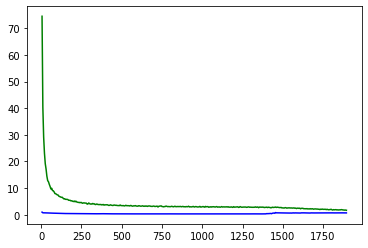

In [203]:
plt.plot(steps, ys_gen, color='g')
plt.plot(steps, ys_dis, color='b')
plt.show()

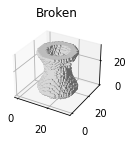

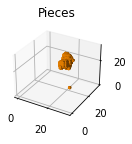

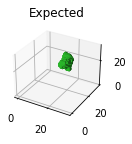

In [204]:
broken = torch.stack([mdl_tr_br[idx], ])
pieces = gen(broken)

broken = broken[0][0].detach().cpu().numpy() > 0
ax1 = plt.figure().add_subplot(1, 3, 1, projection='3d')
ax1.set_title('Broken')
ax1.voxels(broken, facecolors='white', edgecolors='whitesmoke')

pieces = pieces[0][0].detach().cpu().numpy() > 0
ax2 = plt.figure().add_subplot(1, 3, 2, projection='3d')
ax2.set_title('Pieces')
ax2.voxels(pieces & ~broken, facecolors='orange', edgecolors='darkorange')

ax3 = plt.figure().add_subplot(1, 3, 3, projection='3d')
ax3.set_title('Expected')
ax3.voxels(whole & ~broken, facecolors='lime', edgecolors='limegreen')

plt.show()

In [205]:
torch.save(dis.state_dict(), MODELS+'dis.pth')
torch.save(gen.state_dict(), MODELS+'gen.pth')

In [206]:
dataset = np.load(DATASETS+'my_dataset.npy', allow_pickle=True).item()['data']
broken_models = [torch.from_numpy(np.array([model])*2-1).float().to(device) for model in dataset]

loaded = DataLoader(dataset, batch_size=batch_size, shuffle=True)

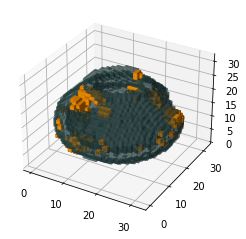

In [207]:
index = np.random.randint(0, len(dataset))

obj = torch.stack([broken_models[index],])
pcs = gen(obj)

obj = obj[0][0].detach().cpu().numpy() > 0
pcs = pcs[0][0].detach().cpu().numpy() > 0

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(obj, facecolors='darkslategray', alpha=0.5)
ax.voxels(pcs & ~obj, facecolors='orange', edgecolors='darkorange')
plt.show()

In [214]:
np.save(MESHES+'ready.npy', {
    'broken': broken,
    'result': pieces & ~broken
})

np.save(MESHES+'ready_custom.npy', {
    'broken': obj,
    'result': pcs
})